# IF on MNIST

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
from torch.autograd.functional import hessian
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
from sklearn.linear_model import LinearRegression
import sklearn.metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hessian on MOG with torch

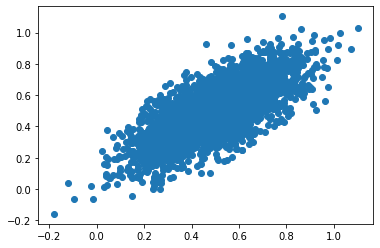

In [ ]:
xx = np.array([0, 1])
yy = np.array([0, 1])
means = [xx.mean(), yy.mean()]  
stds = [xx.std()/3, yy.std()/3]
corr = 0.7         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, num_train).T
scatter(m[0], m[1])

In [ ]:
x_1, y_1 = m.T[0]
x_1, y_1

(0.5183731213232194, 0.6370802042618113)

In [ ]:
model = LinearRegression()
model.fit(np.array([m.T[:,0]]).T, m.T[:,1])

k, b = model.coef_[0], model.intercept_

In [ ]:
k = torch.tensor([k], requires_grad=True)
b = torch.tensor([b], requires_grad=True)
k, b

(tensor([0.7132], dtype=torch.float64, requires_grad=True),
 tensor([0.1427], dtype=torch.float64, requires_grad=True))

In [ ]:
w = torch.tensor([k, b])
w

tensor([0.7132, 0.1427], dtype=torch.float64)

In [ ]:
def parent_mse_loss(w, x, y):
    def MSE_loss(w):
        return (torch.dot(w,torch.tensor([x, 1]))-y)**2
    return MSE_loss

def MSE_loss_all(w):
    Loss = 0
    for i in range(num_train):
        Loss = Loss + (torch.dot(w,torch.tensor([m.T[i][0], 1]))-m.T[i][1])**2
    return Loss

In [ ]:
Hessian = torch.zeros([2,2])
for i in range(num_train):
    Hessian = Hessian + hessian(parent_mse_loss(w, m.T[i][0], m.T[i][1]), w)
Hessian/num_train

tensor([[0.5548, 0.9984],
        [0.9984, 2.0000]], dtype=torch.float64)

In [ ]:
hessian(MSE_loss_all, w)/num_train

tensor([[0.5548, 0.9984],
        [0.9984, 2.0000]], dtype=torch.float64)

## Hessian on MNIST

### Set up before training

In [ ]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download = True)

In [ ]:
input_size = 784 # 28*28
hidden_size = 32
num_classes = 10
num_epochs = 50
batch_size = 50 #100
learning_rate = 0.001

training_size = 3000
testing_size = 1000

In [ ]:
np.random.seed(35)
training_selector = np.random.choice(range(60000), replace = False, size = training_size)
testing_selector = np.random.choice(range(10000), replace = False, size = testing_size)

In [ ]:
class Alpha_Train_Dataset(Dataset):
  def __init__(self):
      
      self.x = train_dataset.data[training_selector].float()
      self.y = train_dataset.targets[training_selector]
      
      #self.n_samples = int(train_dataset.data.shape[0]*alpha)
      self.n_samples = len(training_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class Alpha_Test_Dataset(Dataset):
  def __init__(self):
      
      self.x = test_dataset.data[testing_selector].float()#[random_selector].float()
      self.y = test_dataset.targets[testing_selector]#[random_selector]
      
      self.n_samples = len(testing_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)
  
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

### Training

In [ ]:
alpha_train_dataset = Alpha_Train_Dataset()
train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=batch_size, shuffle=True)

model = NeuralNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        images = images.reshape(-1, 28*28).to(device) # can change -1 to 100
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

alpha_test_dataset = Alpha_Test_Dataset()
test_loader = torch.utils.data.DataLoader(dataset=alpha_test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # 把一个batch reshape 成一个 100 by 784 的 vector 来做prediction
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        output = model(images)
        # value, index
        _, predictions = torch.max(output, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100 * n_correct/n_samples

In [ ]:
acc

87.9

In [ ]:
# with torch.no_grad():
#     out = model(alpha_train_dataset[0][0].reshape(-1, 784).to(device))
#     loss = criterion(out, torch.tensor([alpha_train_dataset[0][1]]))
#     print(loss)

### Calculate Hessian

In [ ]:
def CE_loss(w_1, b_1, w_2, b_2):
    out1 = F.linear(alpha_train_dataset[1][0].reshape(-1, 784).to(device), w_1.reshape(hidden_size,784), b_1)
    out2 = F.relu(out1)
    out3 = F.linear(out2, w_2.reshape(10,hidden_size), b_2)
    loss = criterion(out3, torch.tensor([alpha_train_dataset[1][1]]).to(device))
    return loss

def CE_loss_new(w):
    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10
    out1 = F.linear(alpha_train_dataset[2][0].reshape(-1, 784).to(device), w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
    out2 = F.relu(out1)
    out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])
    loss = criterion(out3, torch.tensor([alpha_train_dataset[2][1]]).to(device))
    return loss

def CE_loss_new_all(w):
    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10

    Loss = []
    for i in range(training_size):
        out1 = F.linear(alpha_train_dataset[i][0].reshape(-1, 784).to(device), w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
        out2 = F.relu(out1)
        out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])
        loss = criterion(out3, torch.tensor([alpha_train_dataset[i][1]]).to(device))
        Loss.append(loss)
    return sum(Loss)

def CE_loss_new_all2(w):
    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10
    
    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=training_size, shuffle=False)
    examples = iter(train_loader)
    images, labels = examples.next()

    out1 = F.linear(images.reshape(-1, 784).to(device), w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
    out2 = F.relu(out1)
    out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])
    loss = criterion(out3, labels.to(device))

    return loss

In [ ]:
#w_1, b_1, w_2, b_2 = list(model.parameters())
#w_1, b_1, w_2, b_2 = [_.view(-1) for _ in model.parameters()]
#CE_loss(w_1, b_1, w_2, b_2)

In [ ]:
# w = torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
# CE_loss_new_all2(w)

In [ ]:
#with torch.no_grad():
#    H = hessian(CE_loss, tuple([_.view(-1) for _ in model.parameters()]))
with torch.no_grad():
   Hessian = hessian(CE_loss_new_all2, torch.cat(tuple([_.view(-1) for _ in model.parameters()])))

In [ ]:
# with torch.no_grad():
#    Hessian = hessian(CE_loss_new, torch.cat(tuple([_.view(-1) for _ in model.parameters()])))

In [ ]:
np_Hessian = Hessian.to("cpu").numpy()/training_size

In [ ]:
damping_matrix = np.diag(np.full(Hessian.shape[0],0.01),0)
damping_matrix

array([[0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.01]])

In [ ]:
damping_hessian = np_Hessian + damping_matrix

#### Save hessian

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
np.save("/content/gdrive/MyDrive/hessian_damping_32_hiddensize", damping_hessian)

#### Save model weight

In [ ]:
w = torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
np_w = w.to("cpu").detach().numpy()

In [ ]:
np.save("/content/gdrive/MyDrive/model_weight_32_hiddensize", np_w)

#### Load hessian and weight

In [ ]:
np_Hessian = np.load("/content/gdrive/MyDrive/hessian_damping_32_hiddensize.npy")

In [ ]:
np_w = np.load("/content/gdrive/MyDrive/model_weight_32_hiddensize.npy")

In [ ]:
inv_hessian = np.linalg.inv(np_Hessian)

In [ ]:
np.save("/content/gdrive/MyDrive/hessian_damping_inverse_32_hiddensize", inv_hessian)

### Calculate loss at test point and train point

test point

In [ ]:
alpha_train_dataset = Alpha_Train_Dataset()
alpha_test_dataset = Alpha_Test_Dataset()
criterion = nn.CrossEntropyLoss()

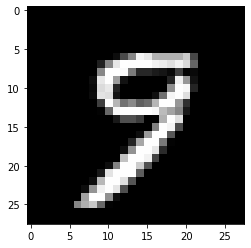

In [ ]:
target_example = alpha_test_dataset[10][0] # it's a 9
plt.imshow(target_example, cmap = "gray")

In [ ]:
def loss_grad_at_point(w, train_point):
    # w should be torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
    # train_point should be alpha_train_dataset[0], a tuple of image and label

    w = w.clone().detach().requires_grad_(True)

    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10

    out1 = F.linear(train_point[0].reshape(-1, 784).to(device), w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
    out2 = F.relu(out1)
    out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])

    loss = criterion(out3, torch.tensor([train_point[1]]).to(device))
    loss.backward()

    return w.grad

In [ ]:
w = torch.tensor(np_w).to(device)

### Calculate if score

In [ ]:
def calculate_if(train_point, test_point, inv_Hessian):
    # test point should be alpha_test_dataset[10]

    test_loss = loss_grad_at_point(w, test_point).to("cpu").numpy()

    train_loss = loss_grad_at_point(w, train_point).to("cpu").numpy()

    if_score = -np.matmul(np.matmul(test_loss.T, inv_Hessian), train_loss)

    return if_score

In [ ]:
if_score_list = []
for i in range(training_size):
    if_score = calculate_if(alpha_train_dataset[i], alpha_test_dataset[10], inv_hessian)
    if_score_list.append(if_score)

### Result

In [ ]:
if_score_series = pd.Series(if_score_list)

In [ ]:
if_score_series_sorted = if_score_series.sort_values(ascending = False)

In [ ]:
if_score_series_sorted

2626    3149.055834
337     3130.842761
1888    2546.111956
2999    2050.485827
779     1238.974530
           ...     
649     -675.471066
1495    -981.742855
1953   -1273.110408
2989   -2615.931615
192    -8228.046355
Length: 3000, dtype: float64

In [ ]:
np.save("/content/gdrive/MyDrive/if_scores_32_hiddensize", np.array(if_score_list))

#### Plot the result

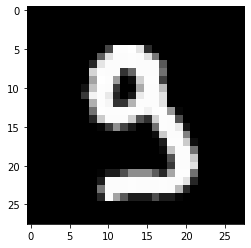

In [ ]:
train_example = alpha_train_dataset[2989][0]
plt.imshow(train_example, cmap = "gray")

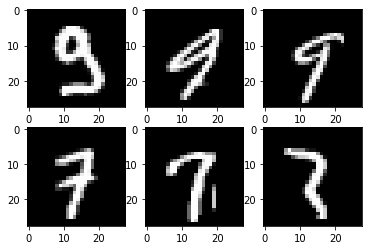

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(alpha_train_dataset[2989][0], cmap = "gray")
axs[0][1].imshow(alpha_train_dataset[1953][0], cmap = "gray")
axs[0][2].imshow(alpha_train_dataset[1495][0], cmap = "gray")
axs[1][0].imshow(alpha_train_dataset[2626][0], cmap = "gray")
axs[1][1].imshow(alpha_train_dataset[337][0], cmap = "gray")
axs[1][2].imshow(alpha_train_dataset[1888][0], cmap = "gray")
